# Predicting the Compressive Strength of High-Performance Concrete using an Interpretable Machine Learning Model

In [1]:
# import relevant 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers.legacy import Adamax, Adam
from scikeras.wrappers import KerasRegressor
import keras.backend as K

import warnings
warnings.filterwarnings("ignore")


## (1) Data Exploration 

In [30]:
# load the dataset
concrete_df = pd.read_csv("concrete.csv")

In [31]:
# display the five five rows 
concrete_df.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [32]:
# display the data information 
concrete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Cement              1030 non-null   float64
 1   Blast Furnace Slag  1030 non-null   float64
 2   Fly Ash             1030 non-null   float64
 3   Water               1030 non-null   float64
 4   Superplasticizer    1030 non-null   float64
 5   Coarse Aggregate    1030 non-null   float64
 6   Fine Aggregate      1030 non-null   float64
 7   Age                 1030 non-null   int64  
 8   Strength            1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB


In [33]:
# count the total number of missing values for each column 
concrete_df.isnull().sum()

Cement                0
Blast Furnace Slag    0
Fly Ash               0
Water                 0
Superplasticizer      0
Coarse Aggregate      0
Fine Aggregate        0
Age                   0
Strength              0
dtype: int64

In [34]:
# count the total number of duplicated rows
concrete_df.duplicated().sum()

25

In [35]:
# remove the duplicated rows 
concrete_df.drop_duplicates(inplace = True)

In [36]:
# re-count the total number of duplicated rows 
concrete_df.duplicated().sum()

0

In [37]:
# rename columns 
concrete_df.rename(columns = {'Cement': 'cement', 
                    'Blast Furnace Slag': 'slag', 
                    'Fly Ash': 'ash', 
                    'Water': 'water', 
                    'Superplasticizer': 'superplasticizer', 
                    'Coarse Aggregate': 'coarseagg', 
                    'Fine Aggregate': 'fineagg', 
                    'Age': 'age', 
                    'Strength': 'comp.strength'}, inplace = True)
concrete_df.head()

,cement,slag,ash,water,superplasticizer,coarseagg,fineagg,age,comp.strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


## (2) Outlier Detection using KNN

In [38]:
from pyod.models.knn import KNN
col = concrete_df.columns
clf = KNN(n_neighbors = 5)
clf.fit(concrete_df.drop(['comp.strength'], axis = 1))

y_pred = clf.predict(concrete_df.drop(['comp.strength'], axis = 1))

outlier_indices = np.where(y_pred == 1)[0]

concrete_df = np.delete(concrete_df, outlier_indices, axis = 0)
concrete_df = pd.DataFrame(concrete_df, columns = col)

In [39]:
concrete_df

,cement,slag,ash,water,superplasticizer,coarseagg,fineagg,age,comp.strength
0,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90.0,47.03
1,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28.0,36.45
2,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28.0,45.85
3,475.0,0.0,0.0,228.0,0.0,932.0,594.0,28.0,39.29
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,90.0,38.07
...,...,...,...,...,...,...,...,...,...
942,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28.0,44.28
943,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28.0,31.18
944,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28.0,23.70
945,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28.0,32.77


## (3) Feature Engineering 

In [40]:
# add new feature: water/cement ratio
concrete_df['water_cement'] = concrete_df.water/ concrete_df.cement

In [41]:
# add new feature: coarse/fine ratio
concrete_df['coarse_fine'] = concrete_df.coarseagg/ concrete_df.fineagg

In [42]:
# add new feature: agg/cement ratio
concrete_df['agg_cement'] = (concrete_df.coarseagg + concrete_df.fineagg)/ concrete_df.cement

In [43]:
# add new feature: ash/cement ratio
concrete_df['ash_cement'] = concrete_df.ash/ concrete_df.cement

In [44]:
# add new feature: slag/ cement ratio 
concrete_df['slag_cement'] = concrete_df.slag/ concrete_df.cement

In [45]:
# add new feature: superplastic/ cement ratio 
concrete_df['superplastic_cement'] = concrete_df.superplasticizer/ concrete_df.cement

In [46]:
# display the concrete data with new added features 
concrete_df.head()

,cement,slag,ash,water,superplasticizer,coarseagg,fineagg,age,comp.strength,water_cement,coarse_fine,agg_cement,ash_cement,slag_cement,superplastic_cement
0,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90.0,47.03,0.857143,1.391045,6.022556,0.0,0.428571,0.0
1,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28.0,36.45,0.600000,1.569024,4.015789,0.0,0.250000,0.0
2,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28.0,45.85,0.857143,1.391045,6.022556,0.0,0.428571,0.0
3,475.0,0.0,0.0,228.0,0.0,932.0,594.0,28.0,39.29,0.480000,1.569024,3.212632,0.0,0.000000,0.0
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,90.0,38.07,0.966767,1.185221,9.083082,0.0,0.666667,0.0


## (4) Feature Selection using Pearson Correlation

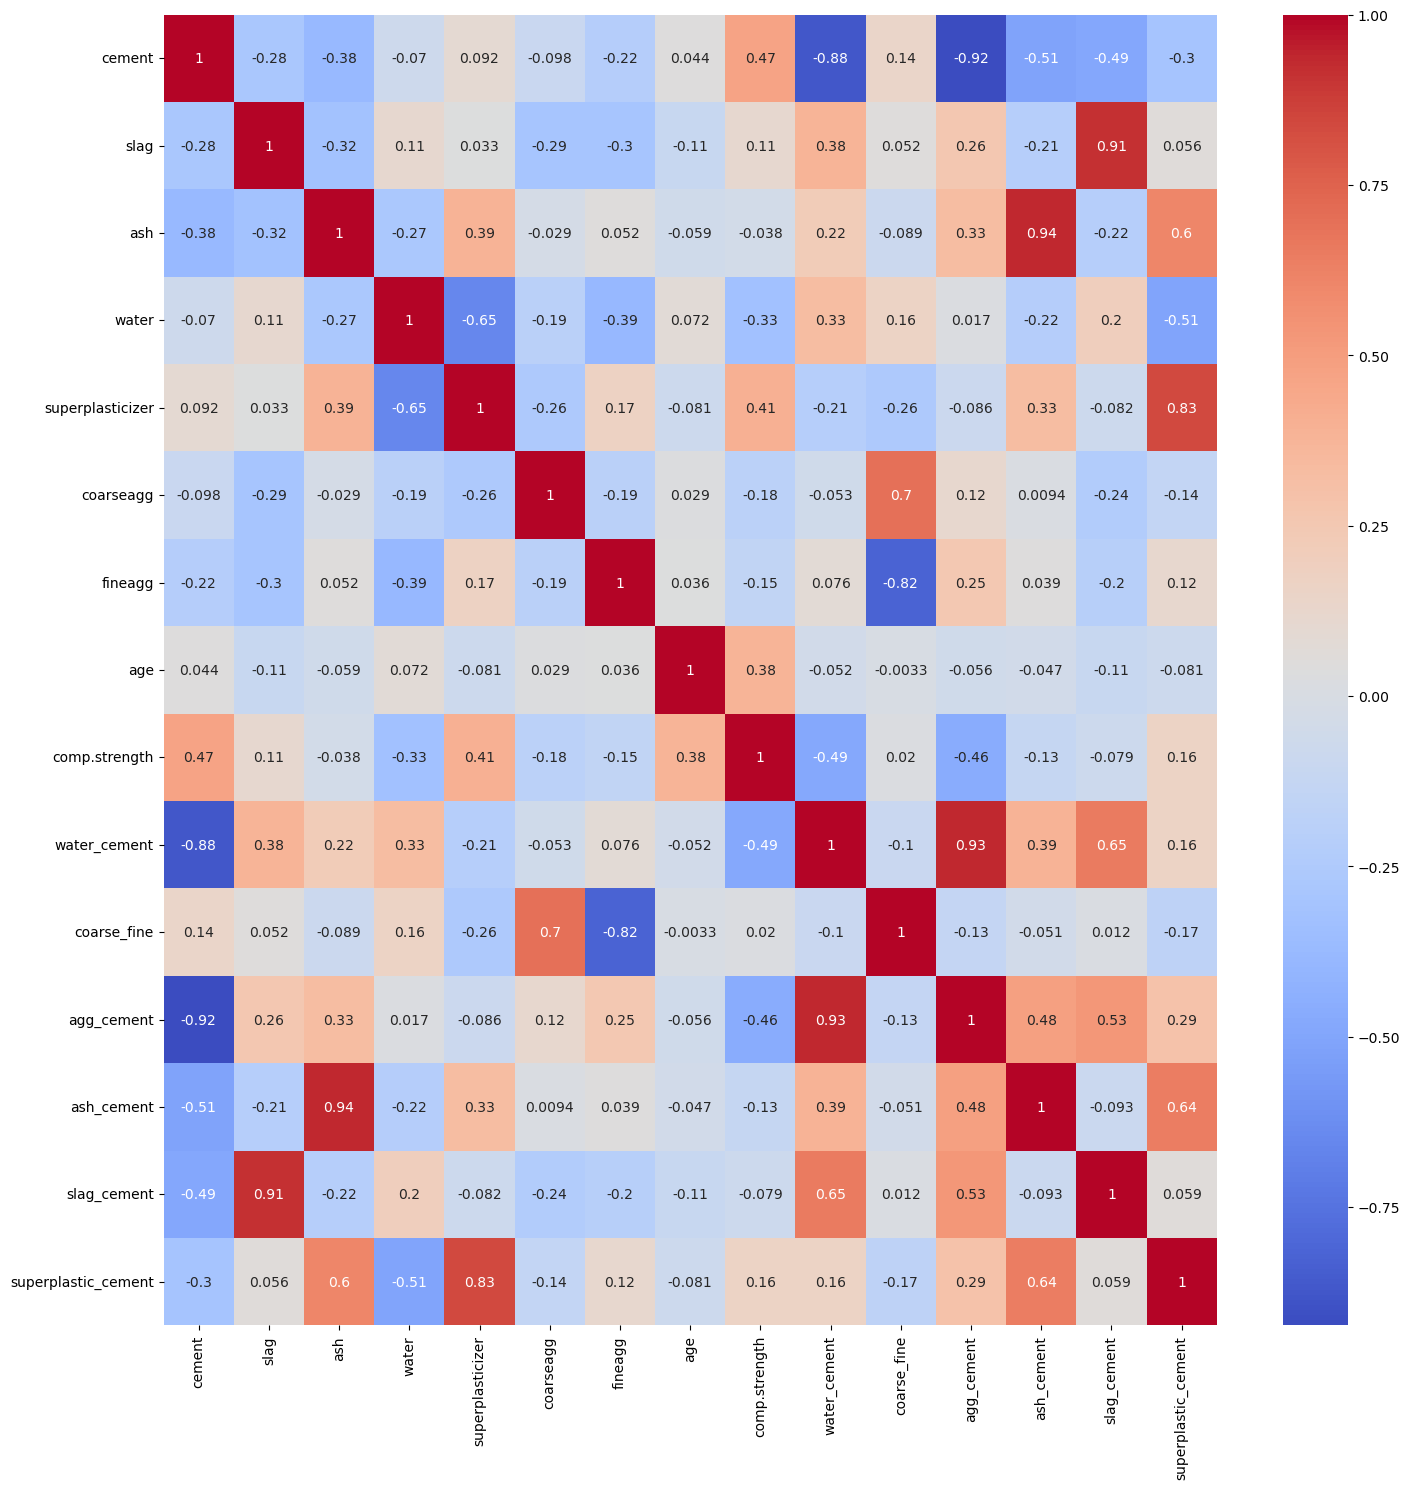

In [47]:
# display the correlation heatmap 
plt.figure(figsize = (15, 15))
sns.heatmap(concrete_df.corr(), annot = True, cmap = 'coolwarm')
plt.tight_layout()
plt.show()

In [48]:
# relationship between the cement and comp.strength 
pearsonr(concrete_df['cement'], concrete_df['comp.strength'])
# p-value = 0.000 < alpha = 5%, statsitically significant correlation 

PearsonRResult(statistic=0.47289460226872826, pvalue=6.243569978925774e-54)

In [ ]:
# relationship between slag and comp.strength 
pearsonr(concrete_df['slag'], concrete_df['comp.strength'])
# p-value = 0.000 < alpha = 5%, statistically significant correlation 

PearsonRResult(statistic=0.11128244570581568, pvalue=0.0006020857388583451)

In [ ]:
# relationship between ash and comp.strength 
pearsonr(concrete_df['ash'], concrete_df['comp.strength'])
# p-value = 0.240 > alpha = 5%, not statsitically significant correlation 
# ash is not selected

PearsonRResult(statistic=-0.038245395543529154, pvalue=0.2396687083507175)

In [52]:
# relationship between water and comp.strength 
pearsonr(concrete_df['water'], concrete_df['comp.strength'])
# p-value = 0.000 < alpha = 5%, statsitically significant correlation 

PearsonRResult(statistic=-0.32735890190980427, pvalue=4.315230631756399e-25)

In [53]:
# relationship between superplasticizer and comp.strength 
pearsonr(concrete_df['superplasticizer'], concrete_df['comp.strength'])
# p-value = 0.000 < alpha = 5%, statsitically significant correlation 

PearsonRResult(statistic=0.40611444782313677, pvalue=6.56886003375363e-39)

In [54]:
# relationship between fineagg and comp.strength 
pearsonr(concrete_df['fineagg'], concrete_df['comp.strength'])
# p-value = 0.000 < alpha = 5%, statsitically significant correlation 

PearsonRResult(statistic=-0.14907178565122728, pvalue=4.0823098958978785e-06)

In [55]:
# relationship between age and comp.strength 
pearsonr(concrete_df['age'], concrete_df['comp.strength'])
# p-value = 0.000 < alpha = 5%, statsitically significant correlation 

PearsonRResult(statistic=0.3786356506349568, pvalue=1.2001135380898201e-33)

In [56]:
# relationship between water_cement and comp.strength 
pearsonr(concrete_df['water_cement'], concrete_df['comp.strength'])
# p-value = 0.000 < alpha = 5%, statsitically significant correlation 

PearsonRResult(statistic=-0.48614986373249625, pvalue=2.4870581903972946e-57)

In [ ]:
# relationship between coarse_fine and comp.strength 
pearsonr(concrete_df['coarse_fine'], concrete_df['comp.strength'])
# p-value = 0.5473 > alpha = 5%, not statsitically significant correlation 
# coarse_fine is not selected

PearsonRResult(statistic=0.019577966681211912, pvalue=0.5473459824329069)

In [58]:
# relationship between agg_cement and comp.strength 
pearsonr(concrete_df['agg_cement'], concrete_df['comp.strength'])
# p-value = 0.000 < alpha = 5%, statsitically significant correlation 

PearsonRResult(statistic=-0.462534322348023, pvalue=2.2419989682443326e-51)

In [59]:
# relationship between ash_cement and comp.strength 
pearsonr(concrete_df['ash_cement'], concrete_df['comp.strength'])
# p-value = 0.000 < alpha = 5%, statsitically significant correlation 

PearsonRResult(statistic=-0.1266780118661327, pvalue=9.271068613797166e-05)

In [ ]:
# relationship between slag_cement and comp.strength 
pearsonr(concrete_df['slag_cement'], concrete_df['comp.strength'])
# p-value = 0.015 < alpha = 5%, statsitically significant correlation 

PearsonRResult(statistic=-0.07864019345905764, pvalue=0.015495914176151445)

In [61]:
# relationship between superplasticizer and comp.strength 
pearsonr(concrete_df['superplasticizer'], concrete_df['comp.strength'])
# p-value = 0.000 < alpha = 5%, statsitically significant correlation 

PearsonRResult(statistic=0.40611444782313677, pvalue=6.56886003375363e-39)

All features are highly statistically significant correlated with compressive strength except ash and coarse_fine, based on the p-values at 5% significance level.

## (5) Model Building & Evaluation

In [62]:
# split the data into 80% training set and 20% testing set 
X_train, X_test, y_train, y_test = train_test_split(concrete_df.drop(['comp.strength', 'coarse_fine', 'ash'], axis = 1), 
                                                    concrete_df['comp.strength'], 
                                                    shuffle = True, 
                                                    test_size = 0.2, 
                                                    random_state = 2025)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(757, 12)
(190, 12)
(757,)
(190,)


In [63]:
# standardize the training and testing sets
col = X_train.columns
scaler = StandardScaler()
X_train[col] = scaler.fit_transform(X_train[col])
X_test[col] = scaler.transform(X_test[col])
X_train.head()

,cement,slag,water,superplasticizer,coarseagg,fineagg,age,water_cement,agg_cement,ash_cement,slag_cement,superplastic_cement
129,-0.406447,-0.836120,0.871264,-0.302301,-0.338345,0.954645,-0.217905,0.279631,0.115671,0.367888,-0.730800,-0.258345
152,-0.827125,-0.836120,-0.933365,0.586111,1.504699,0.305615,-0.789153,0.293306,0.886820,1.101909,-0.730800,1.055673
372,-0.236241,-0.836120,0.620621,-0.101151,0.923441,-0.326405,-0.217905,0.028631,-0.071586,0.558995,-0.730800,-0.120401
853,-1.158832,1.227959,2.029234,0.099999,-1.553107,-2.162271,-0.217905,2.087971,0.706036,2.669151,1.642691,0.765178
170,-0.600829,0.301443,0.059181,0.083237,1.213417,0.080548,0.421894,0.291705,0.448638,-0.472440,0.224097,0.254021


In [64]:
def basemodel():
    ann = Sequential()
    ann.add(Dense(64, input_dim = X_train.shape[1], activation = "selu"))
    ann.add(Dropout(0.15))
    ann.add(Dense(32, activation = "selu"))
    ann.add(Dropout(0.15))
    ann.add(Dense(16, activation = "selu"))
    ann.add(Dropout(0.15))
    ann.add(Dense(1, activation = "relu"))
    ann.compile(loss = "mean_squared_error", optimizer = Adam(learning_rate = 0.01), metrics = ['mean_absolute_error'])
    return ann 

ann_basemodel = KerasRegressor(model = basemodel,
                               epochs = 30,  
                               shuffle = True, 
                               batch_size = 64, 
                               verbose = 1, 
                               random_state = 2025)

with tf.device("/GPU:0"):
    ann_basemodel_res = ann_basemodel.fit(X_train, y_train, validation_split = 0.2)

Epoch 1/30
10/10 [==============================] - 4s 98ms/step - loss: 1204.9862 - mean_absolute_error: 31.2174 - val_loss: 858.2455 - val_mean_absolute_error: 22.7965
Epoch 2/30
10/10 [==============================] - 0s 14ms/step - loss: 1318.5862 - mean_absolute_error: 27.3570 - val_loss: 1210.6877 - val_mean_absolute_error: 24.4468
Epoch 3/30
10/10 [==============================] - 0s 14ms/step - loss: 1257.6743 - mean_absolute_error: 25.1563 - val_loss: 1031.5212 - val_mean_absolute_error: 20.6015
Epoch 4/30
10/10 [==============================] - 0s 14ms/step - loss: 915.4208 - mean_absolute_error: 19.7452 - val_loss: 398.3819 - val_mean_absolute_error: 13.2918
Epoch 5/30
10/10 [==============================] - 0s 14ms/step - loss: 253.9785 - mean_absolute_error: 11.5954 - val_loss: 91.5112 - val_mean_absolute_error: 7.6791
Epoch 6/30
10/10 [==============================] - 0s 13ms/step - loss: 135.5588 - mean_absolute_error: 9.0437 - val_loss: 83.8308 - val_mean_absolute_

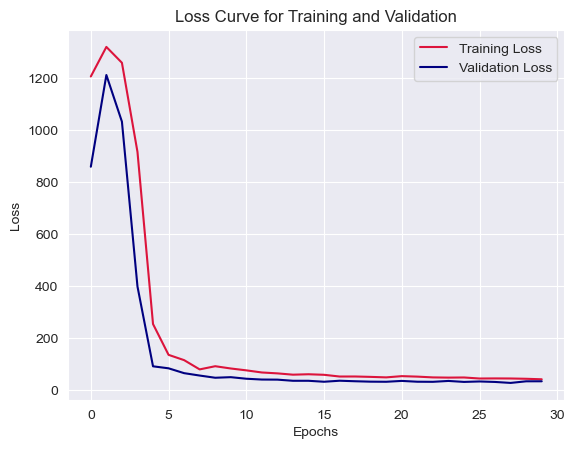

In [65]:
# plot the loss curve for the training and validation 
sns.set_style("darkgrid")
sns.lineplot(ann_basemodel_res.history_['loss'], color = "crimson", label = "Training Loss")
sns.lineplot(ann_basemodel_res.history_['val_loss'], color = "navy", label = "Validation Loss")
plt.title("Loss Curve for Training and Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

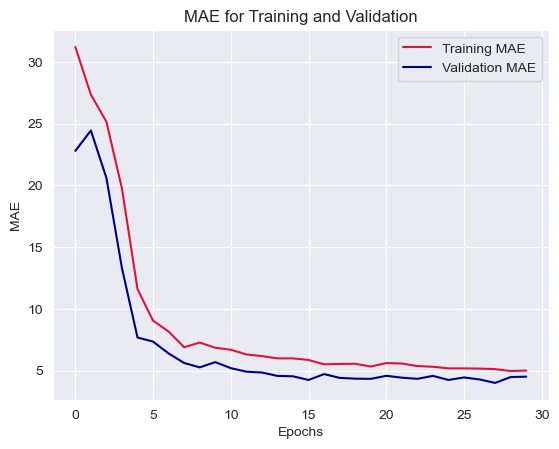

In [66]:
# plot the MAE curve for training and validation 
sns.lineplot(ann_basemodel_res.history_['mean_absolute_error'], color = "crimson", label = "Training MAE")
sns.lineplot(ann_basemodel_res.history_['val_mean_absolute_error'], color = "navy", label = "Validation MAE")
plt.title("MAE for Training and Validation")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.show()

In [67]:
# model evaluation for basemodel
train_pred_basemodel = ann_basemodel.predict(X_train)
test_pred_basemodel = ann_basemodel.predict(X_test)

train_r2_basemodel = r2_score(y_train, train_pred_basemodel)
train_mse_basemodel = mean_squared_error(y_train, train_pred_basemodel)
train_mae_basemodel = mean_absolute_error(y_train, train_pred_basemodel)
train_rmse_basemodel = np.sqrt(mean_squared_error(y_train, train_pred_basemodel))

test_r2_basemodel = r2_score(y_test, test_pred_basemodel)
test_mse_basemodel = mean_squared_error(y_test, test_pred_basemodel)
test_mae_basemodel = mean_absolute_error(y_test, test_pred_basemodel)
test_rmse_basemodel = np.sqrt(mean_squared_error(y_test, test_pred_basemodel))

basemodel_dict = {'Training': {'R2': train_r2_basemodel, 'MSE': train_mse_basemodel, 'MAE': train_mae_basemodel, 'RMSE': train_rmse_basemodel}, 
                  'Testing': {'R2': test_r2_basemodel, 'MSE': test_mse_basemodel, 'MAE': test_mae_basemodel, 'RMSE': test_rmse_basemodel}}
basemodel_eval_df = pd.DataFrame(basemodel_dict)
basemodel_eval_df

3/3 [==============================] - 0s 10ms/step


,Training,Testing
R2,0.873629,0.875408
MSE,32.727756,30.613055
MAE,4.420631,4.247571
RMSE,5.720818,5.532907


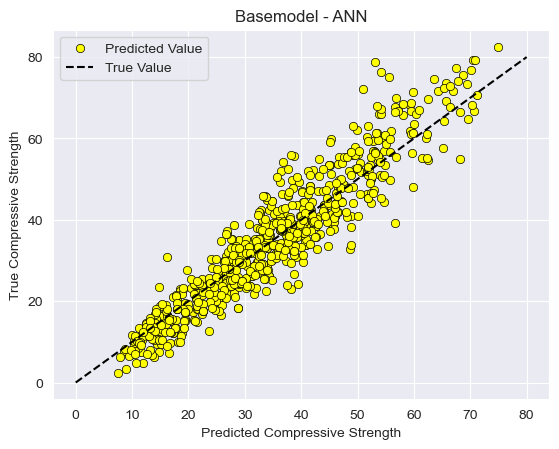

In [68]:
sns.scatterplot(x = train_pred_basemodel, y = np.array(y_train), lw = 0.5, ls = "-", edgecolor = "black", color = "yellow", label = "Predicted Value")
sns.lineplot(x = [0, 80], y = [0, 80], ls = "--", color = "black", label = "True Value")
plt.title("Basemodel - ANN")
plt.xlabel("Predicted Compressive Strength")
plt.ylabel("True Compressive Strength")
plt.show()

## (6) Model Fine-Tuning & Evaluation

In [69]:
best_mae = float("inf")
best_params = {}

for actFunc in ['selu', 'relu', 'gelu', 'elu']:
    for lr in [0.1, 0.01, 0.001]:
        for dropOut in [0.15, 0.2, 0.25]:
            def fine_tune_model():
                ann = Sequential()
                ann.add(Dense(64, input_dim = X_train.shape[1], activation = actFunc))
                ann.add(Dropout(dropOut))
                ann.add(Dense(32, activation = actFunc))
                ann.add(Dropout(dropOut))
                ann.add(Dense(16, activation = actFunc))
                ann.add(Dropout(dropOut))
                ann.add(Dense(1, activation = "relu"))
                ann.compile(loss = "mean_squared_error", optimizer = Adam(learning_rate = lr), metrics = ['mean_absolute_error'])
                return ann 

            ann_ft = KerasRegressor(model = fine_tune_model,
                                        epochs = 30,  
                                        shuffle = True, 
                                        batch_size = 64, 
                                        verbose = 1, 
                                        random_state = 2025)

            with tf.device("/GPU:0"):
                ann_ft_res = ann_ft.fit(X_train, y_train, validation_split = 0.2)
            
            val_mae = ann_ft_res.history_['val_mean_absolute_error'][-1]

            if val_mae < best_mae:
                best_mae = val_mae
                best_params = {'activation': actFunc, 
                               'learning_rate': lr, 
                               'dropout': dropOut}

Epoch 1/30
10/10 [==============================] - 1s 39ms/step - loss: 1941.9889 - mean_absolute_error: 32.5541 - val_loss: 4132.7607 - val_mean_absolute_error: 33.7623
Epoch 2/30
10/10 [==============================] - 0s 18ms/step - loss: 14149.0977 - mean_absolute_error: 43.2240 - val_loss: 3170.0947 - val_mean_absolute_error: 17.2153
Epoch 3/30
10/10 [==============================] - 0s 17ms/step - loss: 719.5578 - mean_absolute_error: 11.2455 - val_loss: 101.0461 - val_mean_absolute_error: 7.6869
Epoch 4/30
10/10 [==============================] - 0s 16ms/step - loss: 117.1277 - mean_absolute_error: 8.0838 - val_loss: 64.9125 - val_mean_absolute_error: 6.1598
Epoch 5/30
10/10 [==============================] - 0s 16ms/step - loss: 92.2214 - mean_absolute_error: 7.4034 - val_loss: 68.2561 - val_mean_absolute_error: 6.5351
Epoch 6/30
10/10 [==============================] - 0s 16ms/step - loss: 87.0969 - mean_absolute_error: 7.2232 - val_loss: 53.0385 - val_mean_absolute_error: 

In [70]:
# display the best mae and parameters
print("Best MAE: {}".format(best_mae))
print("Best Parameters: {}".format(best_params))

Best MAE: 4.1649909019470215
Best Parameters: {'activation': 'gelu', 'learning_rate': 0.1, 'dropout': 0.15}


In [71]:
# rebuild the model using the best parameters
def best_model():
    ann = Sequential()
    ann.add(Dense(64, input_dim = X_train.shape[1], activation = "gelu"))
    ann.add(Dropout(0.15))
    ann.add(Dense(32, activation = "gelu"))
    ann.add(Dropout(0.15))
    ann.add(Dense(16, activation = "gelu"))
    ann.add(Dropout(0.15))
    ann.add(Dense(1, activation = "relu"))
    ann.compile(loss = "mean_squared_error", optimizer = Adam(learning_rate = 0.1), metrics = ['mean_absolute_error'])
    return ann 

ann_bestmodel = KerasRegressor(model = best_model,
                               epochs = 30,  
                               shuffle = True, 
                               batch_size = 64, 
                               verbose = 1, 
                               random_state = 2025)

with tf.device("/GPU:0"):
    ann_bestmodel_res = ann_bestmodel.fit(X_train, y_train, validation_split = 0.2)

Epoch 1/30
10/10 [==============================] - 1s 57ms/step - loss: 607.3727 - mean_absolute_error: 19.7075 - val_loss: 158.7022 - val_mean_absolute_error: 10.2886
Epoch 2/30
10/10 [==============================] - 0s 11ms/step - loss: 220.2150 - mean_absolute_error: 11.4595 - val_loss: 175.9300 - val_mean_absolute_error: 10.2653
Epoch 3/30
10/10 [==============================] - 0s 10ms/step - loss: 164.3113 - mean_absolute_error: 9.7557 - val_loss: 209.1596 - val_mean_absolute_error: 11.7974
Epoch 4/30
10/10 [==============================] - 0s 10ms/step - loss: 187.8208 - mean_absolute_error: 10.6770 - val_loss: 143.9863 - val_mean_absolute_error: 9.6293
Epoch 5/30
10/10 [==============================] - 0s 11ms/step - loss: 143.6484 - mean_absolute_error: 9.2279 - val_loss: 92.3479 - val_mean_absolute_error: 7.3958
Epoch 6/30
10/10 [==============================] - 0s 10ms/step - loss: 108.5378 - mean_absolute_error: 8.1783 - val_loss: 69.5155 - val_mean_absolute_error: 6

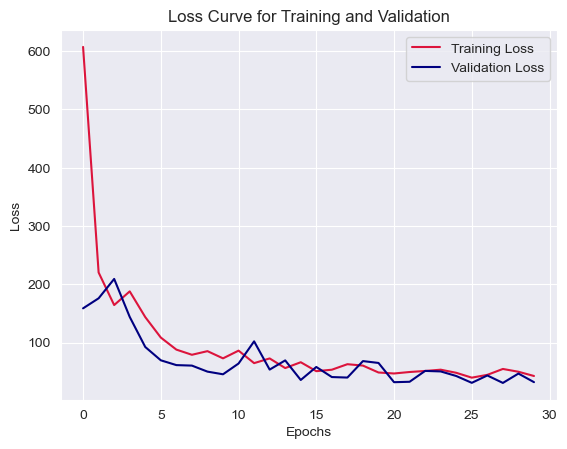

In [72]:
# plot the loss curve for the training and validation 
sns.set_style("darkgrid")
sns.lineplot(ann_bestmodel_res.history_['loss'], color = "crimson", label = "Training Loss")
sns.lineplot(ann_bestmodel_res.history_['val_loss'], color = "navy", label = "Validation Loss")
plt.title("Loss Curve for Training and Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

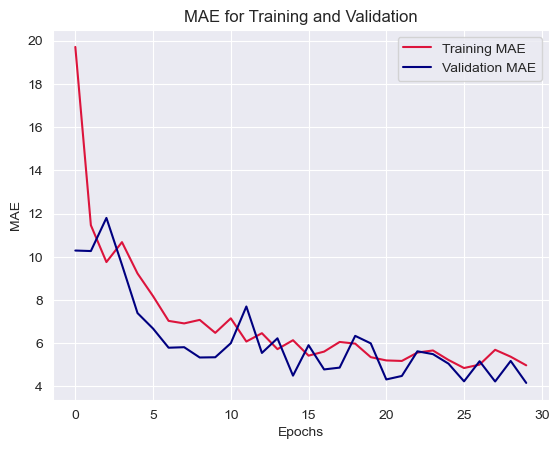

In [73]:
# plot the MAE curve for training and validation 
sns.lineplot(ann_bestmodel_res.history_['mean_absolute_error'], color = "crimson", label = "Training MAE")
sns.lineplot(ann_bestmodel_res.history_['val_mean_absolute_error'], color = "navy", label = "Validation MAE")
plt.title("MAE for Training and Validation")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.show()

In [74]:
# model evaluation for bestmodel
train_pred_bestmodel = ann_bestmodel.predict(X_train)
test_pred_bestmodel = ann_bestmodel.predict(X_test)

train_r2_bestmodel = r2_score(y_train, train_pred_bestmodel)
train_mse_bestmodel = mean_squared_error(y_train, train_pred_bestmodel)
train_mae_bestmodel = mean_absolute_error(y_train, train_pred_bestmodel)
train_rmse_bestmodel = np.sqrt(mean_squared_error(y_train, train_pred_bestmodel))

test_r2_bestmodel = r2_score(y_test, test_pred_bestmodel)
test_mse_bestmodel = mean_squared_error(y_test, test_pred_bestmodel)
test_mae_bestmodel = mean_absolute_error(y_test, test_pred_bestmodel)
test_rmse_bestmodel = np.sqrt(mean_squared_error(y_test, test_pred_bestmodel))

bestmodel_dict = {'Training': {'R2': train_r2_bestmodel, 'MSE': train_mse_bestmodel, 'MAE': train_mae_bestmodel, 'RMSE': train_rmse_bestmodel}, 
                  'Testing': {'R2': test_r2_bestmodel, 'MSE': test_mse_bestmodel, 'MAE': test_mae_bestmodel, 'RMSE': test_rmse_bestmodel}}
bestmodel_eval_df = pd.DataFrame(bestmodel_dict)
bestmodel_eval_df

3/3 [==============================] - 0s 23ms/step


,Training,Testing
R2,0.882270,0.889045
MSE,30.489860,27.262188
MAE,4.134732,3.808544
RMSE,5.521762,5.221321


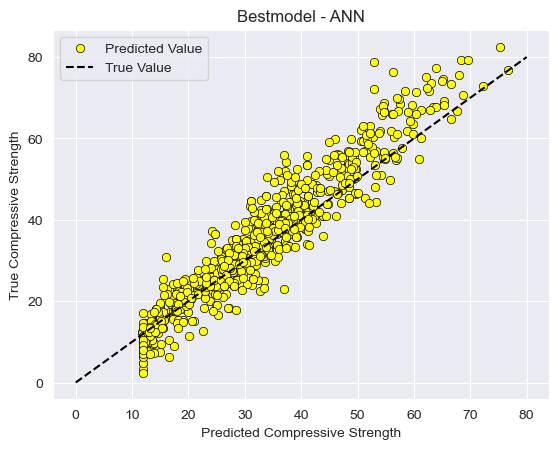

In [75]:
sns.scatterplot(x = train_pred_bestmodel, y = np.array(y_train), lw = 0.5, ls = "-", edgecolor = "black", color = "yellow", label = "Predicted Value")
sns.lineplot(x = [0, 80], y = [0, 80], ls = "--", color = "black", label = "True Value")
plt.title("Bestmodel - ANN")
plt.xlabel("Predicted Compressive Strength")
plt.ylabel("True Compressive Strength")
plt.show()